# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from PIL import Image
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

print(tf.__version__)
import math
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2.3.0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [79]:
train_doc = np.random.permutation(open('../../../Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../../../Project_data/val.csv').readlines())
batch_size = 4 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:

def generator(source_path, folder_list, batch_size, input_shape=(224,224), ablation=None, verbose=0):
    print( 'Source path = ', source_path, '; batch size =', batch_size, '; input_shape =', input_shape, ';ablation =',ablation)
    img_idx = list(range(4,30,5)) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        if ablation!=None:
            new_folder_list=[]
            classes = set([int(line.split(';')[2]) for line in t])
            for label in classes:
                new_folder_list.extend([line for line in t if int(line.split(';')[2])==label][:ablation])
                
            t = np.random.permutation(new_folder_list)
                
        num_batches = int(math.ceil(len(t)/batch_size))# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            cur_batch_size = batch_size
            if len(t)%batch_size!=0 and batch==num_batches-1:
                cur_batch_size = len(t)%batch_size
            batch_data = np.zeros((cur_batch_size,len(img_idx),input_shape[0],input_shape[1],3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((cur_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(cur_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = Image.open(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = image.resize(input_shape)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = np.asarray(image).astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:

curr_dt_time = datetime.datetime.now()
train_path = '../../../Project_data/train'
val_path = '../../../Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


Source path =  ../../../Project_data/train ; batch size = 2 ; input_shape = (224, 224) ;ablation = 10


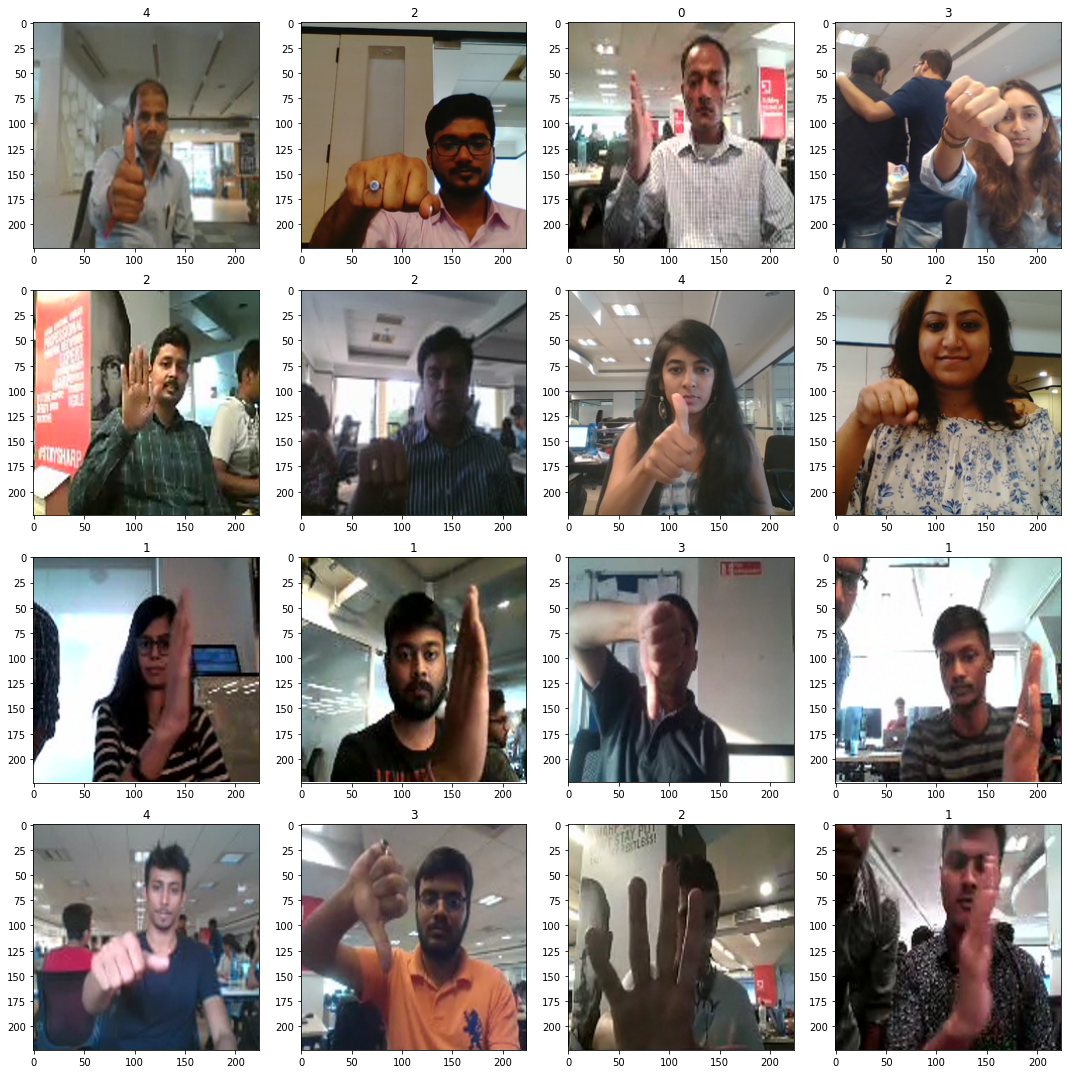

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))
axes = axes.flatten()
fig.tight_layout()
test_generator =  generator(train_path, train_doc, batch_size, ablation=10)
for id in range(16):
    data, label = next(test_generator)
#     print(data.shape, label.shape)
    axes[id].imshow(data[0,0,:,:,:])
    axes[id].title.set_text(str(np.argmax(label[0])))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Input, GlobalAveragePooling3D
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from tensorflow.keras.layers import Flatten,Dense,TimeDistributed,GRU,Conv2D,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

#write your model here

In [8]:
vgg16 = VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [9]:
vgg16.layers[2].compute_output_shape((1,6,224,224,3))

TensorShape([1, 6, 224, 224, 64])

In [10]:
vgg16.layers[3].compute_output_shape((1,6,224,224,3)),vgg16.layers[3].compute_output_shape((1,224,224,3))

(TensorShape([1, 3, 112, 224]), TensorShape([1, 112, 112, 3]))

In [11]:
vgg16.layers

In [76]:
model_1 = Sequential(vgg16.layers[:3])

In [77]:
model_1.compute_output_shape((1,6,224,224,3)),model_1.compute_output_shape((1,224,224,3))

(TensorShape([1, 6, 224, 224, 64]), TensorShape([1, 224, 224, 64]))

In [14]:
images,labels = next(test_generator)
image = images[0,0]
image.shape

(224, 224, 3)

In [15]:
image = images[1,0]
image.shape

(224, 224, 3)

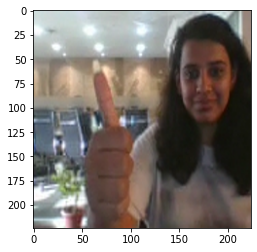

In [16]:
plt.imshow(image)

In [17]:
result_image_1 = model_1(tf.expand_dims(image,axis=0))
result_image_1.shape

TensorShape([1, 224, 224, 64])

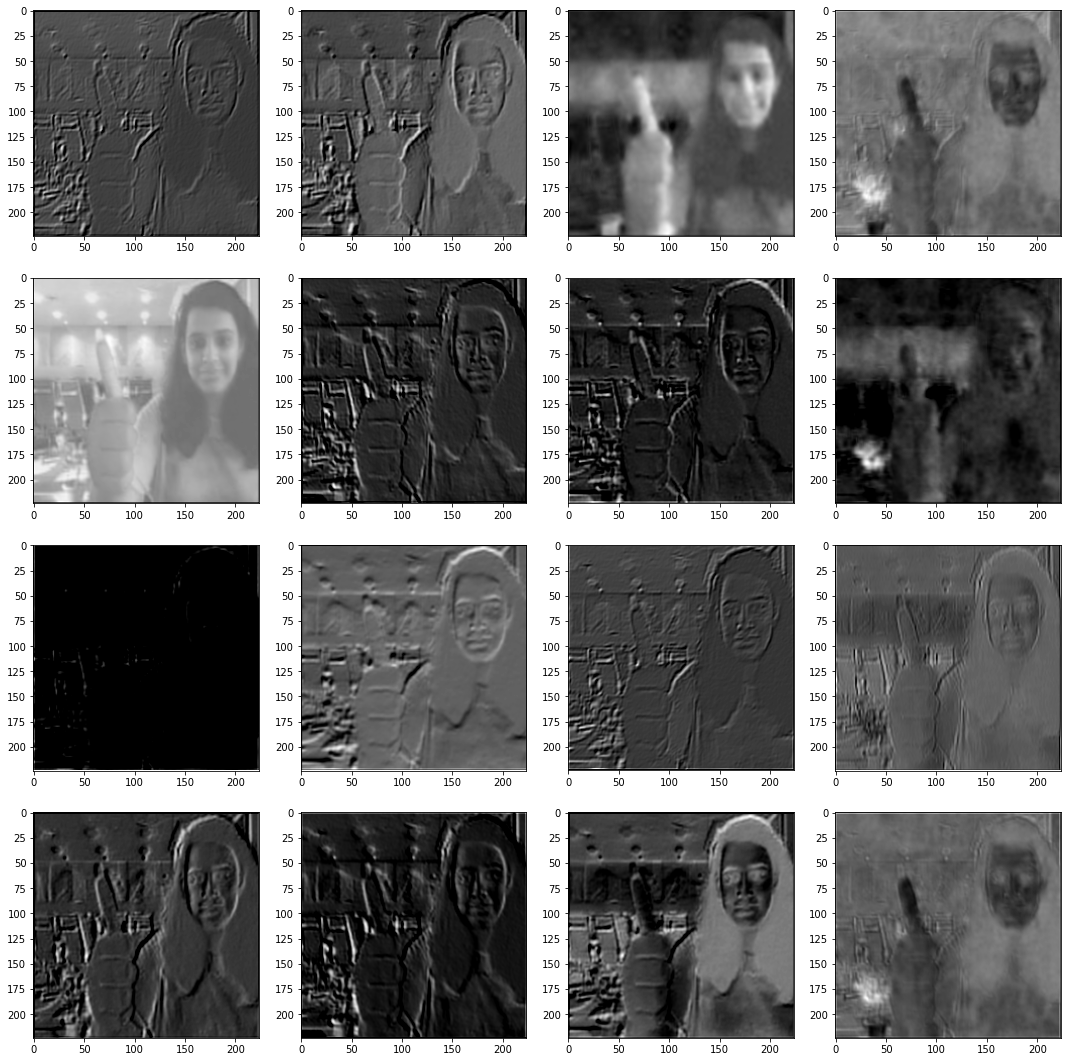

In [18]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))
axes = axes.flatten()
fig.tight_layout()
for id in range(16):
    axes[id].imshow(result_image_1[0,:,:,id], cmap='gray')
#     axes[id].title.set_text(str(np.argmax(label[0])))

In [19]:
vgg16.layers[:13]

In [20]:
model_2 = Sequential(vgg16.layers[:10])

In [21]:
result_image_2 = model_2(tf.expand_dims(image,axis=0))
result_image_2.shape

TensorShape([1, 56, 56, 256])

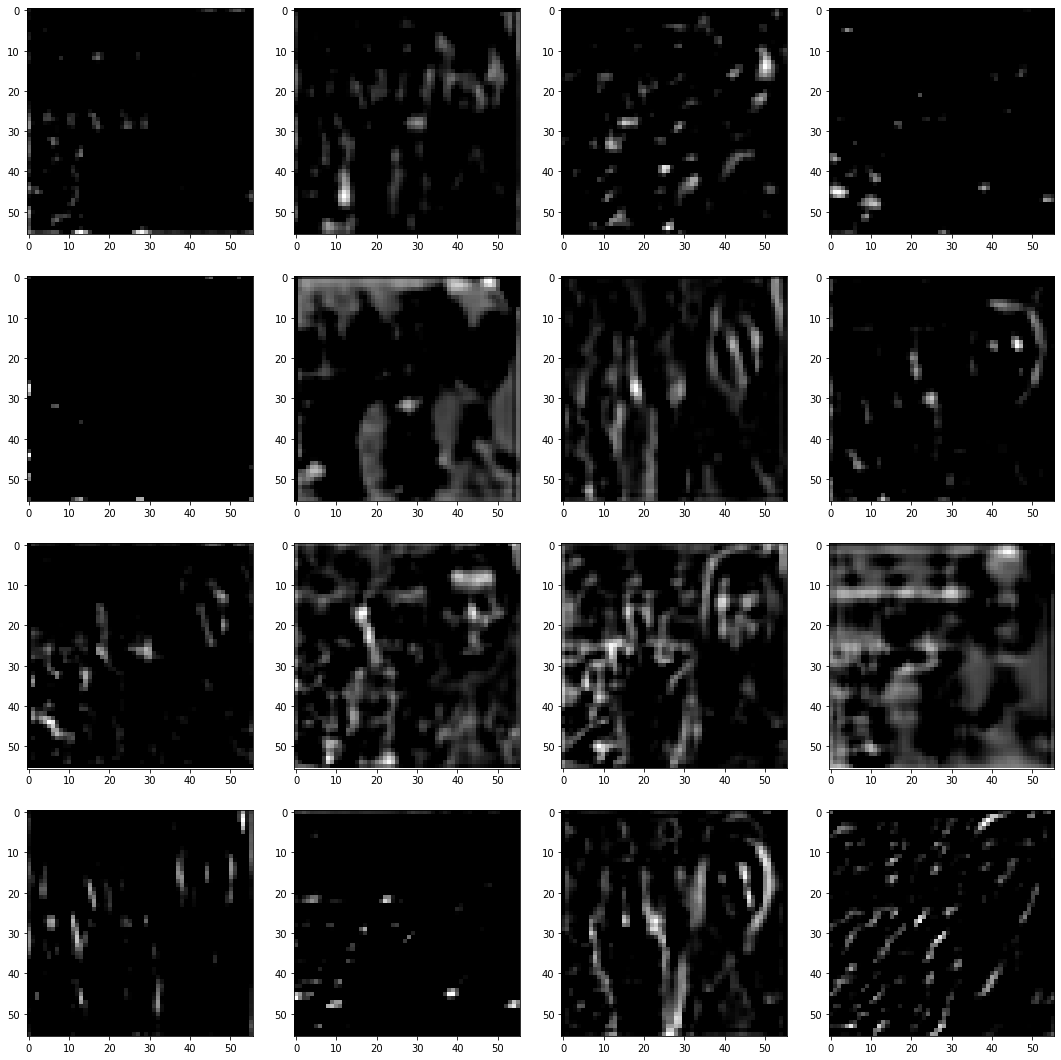

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(15,15))
axes = axes.flatten()
fig.tight_layout()
for id in range(16):
    axes[id].imshow(result_image_2[0,:,:,id], cmap='gray')
#     axes[id].title.set_text(str(np.argmax(label[0])))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [23]:
vgg16.layers[3].compute_output_shape(input_shape=(None,6,224,224,3))

TensorShape([None, 3, 112, 224])

In [24]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


In [78]:
model_1.trainable=False 

In [65]:
cnn = Sequential()
cnn.add(model_1)
tf.keras.layers.MaxPool3D(
    pool_size=(2, 2, 2), strides=None)
cnn.add(Conv3D(64,3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool3D(
    pool_size=(2, 2, 2), strides=[1,2,2],padding='same'))
cnn.add(Conv3D(128,3, activation='relu',padding='same'))
cnn.add(Conv3D(128,3, activation='relu',padding='same'))
cnn.add(tf.keras.layers.MaxPool3D(
    pool_size=(2, 2, 2), strides=[1,2,2],padding='same'))
cnn.add(Conv3D(128,3, activation='relu',padding='same'))
cnn.add(Conv3D(128,3, activation='relu',padding='same'))
cnn.add(tf.keras.layers.MaxPool3D(
    pool_size=(2, 2, 2),padding='same'))
cnn.add(Flatten()) #256
cnn.add(Dense(1024,activation='relu'))
cnn.add(Dense(256,activation='relu'))
cnn.add(Dense(32,activation='relu'))
cnn.add(Dense(5,activation='softmax'))
cnn.build(input_shape=(None,6,224,224,3))
cnn.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 64)      38720     
_________________________________________________________________
conv3d_93 (Conv3D)           (None, 4, 222, 222, 64)   110656    
_________________________________________________________________
max_pooling3d_85 (MaxPooling (None, 4, 111, 111, 64)   0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 4, 111, 111, 128)  221312    
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 4, 111, 111, 128)  442496    
_________________________________________________________________
max_pooling3d_86 (MaxPooling (None, 4, 56, 56, 128)    0         
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 4, 56, 56, 128)  

In [67]:
cnn.compute_output_shape((1,6,224,224,3))

TensorShape([1, 5])

In [68]:
optimiser = tf.keras.optimizers.SGD(lr=0.001) #write your optimizer
cnn.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (cnn.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 64)      38720     
_________________________________________________________________
conv3d_93 (Conv3D)           (None, 4, 222, 222, 64)   110656    
_________________________________________________________________
max_pooling3d_85 (MaxPooling (None, 4, 111, 111, 64)   0         
_________________________________________________________________
conv3d_94 (Conv3D)           (None, 4, 111, 111, 128)  221312    
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 4, 111, 111, 128)  442496    
_________________________________________________________________
max_pooling3d_86 (MaxPooling (None, 4, 56, 56, 128)    0         
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 4, 56, 56, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [80]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [82]:
model_name = '../../../cnn3d_vgg/model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [83]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [84]:
history = cnn.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../../../Project_data/train ; batch size = 4 ; input_shape = (224, 224) ;ablation = None
Epoch 1/10
166/166 [==============================] - ETA: 0s - loss: 0.3972 - categorical_accuracy: 0.8567
Epoch 00001: saving model to ../../../cnn3d_vgg/model_init_2021-12-2422_38_04.546451/model-00001-0.39723-0.85671-0.98767-0.62000.h5
166/166 [==============================] - 83s 502ms/step - loss: 0.3972 - categorical_accuracy: 0.8567 - val_loss: 0.9877 - val_categorical_accuracy: 0.6200
Epoch 2/10
166/166 [==============================] - ETA: 0s - loss: 0.2386 - categorical_accuracy: 0.9170
Epoch 00002: saving model to ../../../cnn3d_vgg/model_init_2021-12-2422_38_04.546451/model-00002-0.23856-0.91704-1.49174-0.52000.h5
166/166 [==============================] - 90s 543ms/step - loss: 0.2386 - categorical_accuracy: 0.9170 - val_loss: 1.4917 - val_categorical_accuracy: 0.5200
Epoch 3/10
166/166 [==============================] - ETA: 0s - loss: 0.1238 - categorical_accuracy:

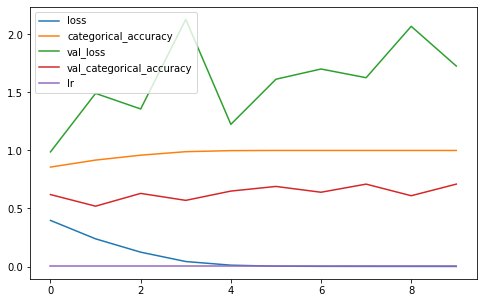

In [86]:
import pandas as pd
plt = pd.DataFrame(history.history).plot(figsize=(8,5))

In [88]:
plt.figure.savefig('../model_history/history_conv3d_vgg.png')